In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [2]:
data = pd.read_csv(r'data.csv', parse_dates=['created_at'])
df = pd.DataFrame(data)

## DECODING DEL TESTO ALL INTERNO DELLA COLONNA `text`. 
All interno della colonna text è presente una rappresentazione di un bytes sotto forma di stringa. Questa può essere valutata attraverso la funzione `ast.literal_eval(string)` e quindi decodificata
#secondo la codifica appropriata tramite il metodo decode

In [3]:
text_enc = []
for i in range(0, df.text.size):
    txt= ast.literal_eval(df.text[i]).decode('utf-8')
    text_enc.append(txt)

df['text_enc'] = text_enc
df

,favorite_count,source,text,is_retweet,created_at,retweet_count,text_enc
0,1,Twitter for Android,b'La #monarqu\xc3\xada se burla a diario de lo...,False,2021-03-03 07:46:48+00:00,0,La #monarquía se burla a diario de los español...
1,0,Twitter for iPhone,b'@TitusNation the CON serving CONservative GO...,False,2021-03-03 17:22:21+00:00,0,@TitusNation the CON serving CONservative GOP ...
2,0,Twitter for Android,b'#Coronavirus\nAustria and Denmark are to sto...,False,2021-03-03 08:47:26+00:00,0,#Coronavirus\nAustria and Denmark are to stop ...
3,0,Twitter Web App,b'BMC launches \xe2\x80\x98Mission Zero\xe2\x8...,False,2021-03-01 12:23:57+00:00,0,BMC launches ‘Mission Zero’ in Mumbai again to...
4,0,Twitter for iPhone,b'@Gadaffyduck @IsabelOakeshott @AmandaHolden ...,False,2021-03-04 20:49:11+00:00,0,@Gadaffyduck @IsabelOakeshott @AmandaHolden Du...
...,...,...,...,...,...,...,...
4163,4,Tweetbot for Mac,"b'In other news, I have been jabbed with the f...",False,2021-03-02 19:18:52+00:00,0,"In other news, I have been jabbed with the fir..."
4164,5,Twitter Web App,"b""So nearly 10% of today's new cases are the n...",False,2021-03-04 22:56:28+00:00,4,So nearly 10% of today's new cases are the new...
4165,2,Twitter for Android,"b""Read this\n\nThen read it again\n\nWritten, ...",False,2021-03-04 07:46:47+00:00,1,"Read this\n\nThen read it again\n\nWritten, pr..."
4166,8,Twitter Web App,b'\xe2\x80\xbc\xef\xb8\x8fUpdate\xe2\x80\xbc\x...,False,2021-03-04 12:39:09+00:00,4,‼️Update‼️ Individuals who file an IRS Form 1...


## Pulizia dei Tweet
Attraverso le Regular Expressions vado a rimuovere elementi come:
* @menzioni
* Hashtag
* Link

In [4]:
import re

def cleanTxt(text):
 text=text.lower()
 text = re.sub('\S*trump\S*', 'trump', text)
 text = re.sub('\S*biden\S*', 'biden', text)
 text = re.sub('\S*clinton\S*', 'clinton', text)
 text = re.sub('@\S+', '', text) #Rimuove le @menzioni
 text = re.sub('#', '', text) # Rimuove l'hashtag
 text = re.sub('https?:\/\/\S+', '', text) # Rimuove i link
 text = re.sub('&amp', '', text) #Rimuove &amp
 text = re.sub('covid-19', 'covid', text ) #converte covid-19 in covid
 text = re.sub('covid19', 'covid', text ) #converte covid19 in covid
 text = re.sub('covid 19', 'covid', text ) #converte covid 19 in covid
 text = re.sub('coronavirus', 'covid', text)
 return text

def countMentions(text):
    return len(re.findall('@\S+', text))

def countHashtags(text):
    return len(re.findall('#', text))

def countLinks(text):
    return len(re.findall('https?:\/\/\S+', text))


df.text_enc=df.text_enc.astype('str')
df['text_clean'] = df.text_enc.apply(cleanTxt)
df['mentions'] = df.text_enc.apply(countMentions)
df['hashtags'] = df.text_enc.apply(countHashtags)
df['links'] = df.text_enc.apply(countLinks)


In [12]:
df

,favorite_count,source,text,is_retweet,created_at,retweet_count,text_enc,text_clean,mentions,hashtags,links
0,1,Twitter for Android,b'La #monarqu\xc3\xada se burla a diario de lo...,False,2021-03-03 07:46:48+00:00,0,La #monarquía se burla a diario de los español...,la monarquía se burla a diario de los españole...,0,7,1
1,0,Twitter for iPhone,b'@TitusNation the CON serving CONservative GO...,False,2021-03-03 17:22:21+00:00,0,@TitusNation the CON serving CONservative GOP ...,the con serving conservative gop = ghouls of ...,1,1,0
2,0,Twitter for Android,b'#Coronavirus\nAustria and Denmark are to sto...,False,2021-03-03 08:47:26+00:00,0,#Coronavirus\nAustria and Denmark are to stop ...,covid\naustria and denmark are to stop relying...,0,2,1
3,0,Twitter Web App,b'BMC launches \xe2\x80\x98Mission Zero\xe2\x8...,False,2021-03-01 12:23:57+00:00,0,BMC launches ‘Mission Zero’ in Mumbai again to...,bmc launches ‘mission zero’ in mumbai again to...,0,0,1
4,0,Twitter for iPhone,b'@Gadaffyduck @IsabelOakeshott @AmandaHolden ...,False,2021-03-04 20:49:11+00:00,0,@Gadaffyduck @IsabelOakeshott @AmandaHolden Du...,dude.. y’all sound like the idiots. y’all b...,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4163,4,Tweetbot for Mac,"b'In other news, I have been jabbed with the f...",False,2021-03-02 19:18:52+00:00,0,"In other news, I have been jabbed with the fir...","in other news, i have been jabbed with the fir...",0,0,0
4164,5,Twitter Web App,"b""So nearly 10% of today's new cases are the n...",False,2021-03-04 22:56:28+00:00,4,So nearly 10% of today's new cases are the new...,so nearly 10% of today's new cases are the new...,0,1,1
4165,2,Twitter for Android,"b""Read this\n\nThen read it again\n\nWritten, ...",False,2021-03-04 07:46:47+00:00,1,"Read this\n\nThen read it again\n\nWritten, pr...","read this\n\nthen read it again\n\nwritten, pr...",0,0,1
4166,8,Twitter Web App,b'\xe2\x80\xbc\xef\xb8\x8fUpdate\xe2\x80\xbc\x...,False,2021-03-04 12:39:09+00:00,4,‼️Update‼️ Individuals who file an IRS Form 1...,‼️update‼️ individuals who file an irs form 1...,1,1,3


## Language Detection
il metodo `detect_langs` fornisce un vettore di possibilità riguardo la lingua del testo che sta analizzando. Vado a vedere se ci sono nel dataset testi ambigui (quindi quelli per cui la dimensione del `dict` ritornato da `detect_langs` è maggiore di 1).

Utilizzo `langdetect` che è abbastanza veloce per generare una previsione sommaria. Esso restituisce la probabilità per ciascuna lingua trovata quindi:
* se trovo una sola lingua tra quelle ammesse (en, es, fr) allora segno la lingua trovata e segno la detection come sicura
* se trovo più di una lingua oppure trovo come lingua più probabile una non ammessa segno la lingua e segno la detection come insicura/sbagliata (`unsure_wrong_detection=True`) 

In [14]:
from langdetect import detect_langs

unsure_count = 0
wrong_count = 0
i=0
lang_detect = []
unsure_wrong = []

for twt in df.text_enc:
    try:
        detection = detect_langs(twt)
        lang = detection[0].lang
        
        lang_detect.append(lang)
        unsure_wrong.append(False)
        
        if((lang != "en") and (lang != "es") and (lang != "fr")):
             wrong_count = wrong_count +1
             unsure_wrong[i]=True
        if(len(detection)>1):
            unsure_wrong[i]=True
            unsure_count = unsure_count+1

    except:
        print("errore alla posizione ")
        i
        print("testo : " + twt)
        lang_detect.append('None')
        unsure_wrong.append(True)

    i=i+1



df['langdetect']=lang_detect
df['unsure_wrong_detection'] = unsure_wrong

unsure_wrong_sum = df['unsure_wrong_detection'].sum()
unsure_wrong_sum

errore alla posizione 
testo : Vamos
⤵⤵⤵⤵⤵⤵⤵⤵⤵⤵⤵⤵ https://t.co/DJw64hxzfj


348

# Check traduzione attraverso API Google 
I tweet dei quali la traduzione non è sicura sono stati marcati con un `True` all'interno della colonna `unsure_wrong_detection`. Utilizzo questa informazione per passare i questi tweet all'interno dell'API Google per la traduzione. Questo metodo non è stato utilizzato prima in quanto le possibili chiamate ai server Google sono limitate e molto lente.

In [16]:
from textblob import TextBlob

lang_detect_final = []
i = 0
for twt in df.text_clean:
    if not df['unsure_wrong_detection'][i]:
        lang_detect_final.append(df['langdetect'][i])
    else:
        blob = TextBlob(twt)
        lang = blob.detect_language()
        if((lang != "en") and (lang != "es") and (lang != "fr")):
            lang_detect_final.append('None')
        else:
            lang_detect_final.append(lang)
            df['unsure_wrong_detection'][i]=False
    i=i+1

df['lang_detect_final'] = lang_detect_final

C:\Users\giuli\AppData\Local\Temp/ipykernel_19100/392722462.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unsure_wrong_detection'][i]=False


In [17]:
df.unsure_wrong_detection.sum() #numero totale di tweet di cui non è stata identificta la lingua

34

## Esportazione dei dati su formato Excel
Excel non supporta le date con le timezone quindi le ho dovute eliminare con il metodo `datetime.tz_localize()`

In [19]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [20]:
df_enc = df[['favorite_count', 'source', 'text_enc', 'text_clean', 'is_retweet', 'retweet_count', 'created_at', 'langdetect' , 'unsure_wrong_detection', 'lang_detect_final']]
df_enc.loc[:,'created_at_ntz']= df_enc.created_at.dt.tz_localize(None)

df_enc = df_enc.drop(columns='created_at')
df_enc.to_excel('data_dec.xlsx')

C:\Users\giuli\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


# Inizio dell'analisi
Dopo aver salvato i dati ripuliti all'interno del file Excel, uso questo come checkpoint per partire con l'analisi. Questo perché non è sempre possibile performare di nuovo la traduzione a causa delle restrizioni dell'api di Google descritte sopra

Dal momento che i Tweet la cui lingua non è stata riconosciuta sono meno dell' 1%, questi vengono filtrati. Dopodiché il dataset viene splittato per lingua in tre ```DataFrame``` 


In [5]:
data=pd.read_excel(r'data_dec.xlsx')
df=pd.DataFrame(data)

df = df.drop(columns='langdetect')
df.loc[df['unsure_wrong_detection']==True].shape #controllo dei tweet la cui lingua non è stata riconosciuta
df = df.loc[df['unsure_wrong_detection']==False] #filtraggio dei tweet non riconosciuti

### Suddivisione dei Dataset per lingua ###

#en
df_en = df.loc[df['lang_detect_final']=='en']
df_en = df_en.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#es
df_es = df.loc[df['lang_detect_final']=='es']
df_es = df_es.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])

#fr
df_fr = df.loc[df['lang_detect_final']=='fr']
df_fr = df_fr.drop(columns=['lang_detect_final', 'unsure_wrong_detection'])


In [6]:
#questo blocco di codice è inutile se si fanno runnare tutti i blocchi dall'inizio

df_en.text_enc=df_en.text_enc.astype('str')
df_en['text_clean'] = df_en.text_enc.apply(cleanTxt)
df_en['mentions'] = df_en.text_enc.apply(countMentions)
df_en['hashtags'] = df_en.text_enc.apply(countHashtags)
df_en['links'] = df_en.text_enc.apply(countLinks)

df_en.to_excel('dataen.xlsx')

## Preprocessing del testo
Attraverso la libreria ```nltk``` viene effettuato il preprocessing del testo. Ogni tweet viene tokenizzato in parole che vengono filtrate dalle stopwords e stemmate attraverso il ```PorterStemmer```. I tweet, una volta stemmati vengono salvati nella colonna text_stem e quindi per comodità de-tokenizzati.

In [7]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

df_en.text_clean=df_en.text_clean.astype('str')

text_stem = []
#df_en['text_clean']=df_en['text_clean'].astype('str')

for twt in df_en.text_clean:
    tweet = twt.lower()
    token_words = word_tokenize(tweet) #tokenizzazione
    token_filter_words = [w for w in token_words if not w in stop_words] #stopword filtering
    stem_sentence=[]
    for word in token_filter_words:
        stem_sentence.append(porter.stem(word)) #stemming
        stem_sentence.append(' ')
    
    text_stem.append(''.join(stem_sentence))

df_en['text_stem']=text_stem

## Tf-Idf
A questo punto viene performata la Tf-Idf sui tweet stemmati al punto precedenti. 

La Tf-idf viene effettuata utilizzando il parametro ```min_df``` che filtra le parole in base alla loro frequenza nel dataset: se ```min_df=0.005``` allora verranno filtrate tutte le parole che compaiono in meno del 0,5% dei tweet. Questo permette di ridurre drasticamente il numero di feature e l'analisi verrà effettuata utilizzando varie percentuali minime. Il parametro ```max_df``` è l'analogo per la frequenza massima. 

Per comodità di visualizzazione viene creato un dataframe per visualizzare la matrice tf-idf e generare una classifica delle parole: lo score di ciascuna parola è la media del tf-idf della parola in tutti i tweet. Vengono visualizzati i termini con score maggiore.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(data, mindf,  lan='english'):

    tfidfVectorizer = TfidfVectorizer(min_df=mindf,
                                    stop_words=lan)
    tfidf_matrix = tfidfVectorizer.fit_transform(data['text_stem'])

    print("sono state prodotte", len(tfidfVectorizer.get_feature_names()), "parole nel processo di tf-idf con mindf=", mindf)
    ## Conversione TfIdf in Dataframe ##

    # tfidfVectorizer ritorna una matrice sparsa che non permette la visualizzazione agevole della matrice TfIdf

    tf_idf = pd.DataFrame(columns=tfidfVectorizer.get_feature_names(), index=data['text_clean'], dtype=float)
    
    M=tfidf_matrix.todense()
    for i in range(0, data.shape[0]):
        tf_idf.iloc[i, :]=M[i,:]

    ## classifica delle parole
    #score={}
    #for word in tfidfVectorizer.get_feature_names():
    #    score[word]= tf_idf_en[word].mean()

    #score_sroted = dict(sorted(score.items(), key=lambda item: item[1], reverse=True))
    #print("Score delle prime 10 parole: ", list(score_sroted.items())[0:10])

    return tf_idf, M



In [9]:
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0)
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0.001)
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0.005)
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0.01)
tf_idf_en, tfidf_en_matrix=tfidf(df_en, 0.05)

sono state prodotte 8025 parole nel processo di tf-idf con mindf= 0
sono state prodotte 1788 parole nel processo di tf-idf con mindf= 0.001
sono state prodotte 411 parole nel processo di tf-idf con mindf= 0.005
sono state prodotte 167 parole nel processo di tf-idf con mindf= 0.01
sono state prodotte 6 parole nel processo di tf-idf con mindf= 0.05


## Scelta del numero di feature
Proseguo l'analisi con una mindf di 0.001, 0.005 e 0.01

In [10]:
tf_idf_en_01, tfidf_en_matrix_01 = tfidf(df_en, 0.001)
tf_idf_en_05, tfidf_en_matrix_05 = tfidf(df_en, 0.005)
tf_idf_en_10, tfidf_en_matrix_10 = tfidf(df_en, 0.01)

tf_idf_en_00, tfidf_en_matrix_00 = tfidf(df_en, 0)

sono state prodotte 1788 parole nel processo di tf-idf con mindf= 0.001
sono state prodotte 411 parole nel processo di tf-idf con mindf= 0.005
sono state prodotte 167 parole nel processo di tf-idf con mindf= 0.01
sono state prodotte 8025 parole nel processo di tf-idf con mindf= 0


In [12]:
tfidf_en_matrix_01

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.48543797, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

## PCA vs ```min_df```
Provo a ridurre le features non alla cieca come il parametro ```min_df``` della Tf Idf ma preservando le informazioni all'interno del dataset.
La PCA è giustificata dalla non necessità di interpretare le feature.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def feature_redux(M):
    original_size=M.shape[1]
    #Standardizzo i dati
    scaler = StandardScaler()
    M_redux = scaler.fit_transform(M)

    #Applico la PCA mantenendo il 95% della varianza
    pca=PCA(0.90)
    M_redux = pca.fit_transform(M_redux)

    print("Il numero di feature è stato ridotto da ",original_size,"a", pca.n_components_)

    #scatter 3d dei punti prodotti
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import pyplot

    figure = pyplot.figure()
    ax = Axes3D(figure)

    ax.scatter(M_redux[:,0], M_redux[:,1], M_redux[:,2])
    pca.explained_variance_
    pyplot.show()

    return M


Il numero di feature è stato ridotto da  8025 a 1879
C:\Users\giuli\AppData\Local\Temp/ipykernel_14060/1849808391.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure)


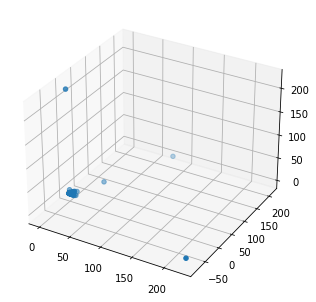

In [13]:
tfidf_en_matrix_PCA = feature_redux(tfidf_en_matrix_00)

# K-means Clustering
Viene performato un algoritmo di K-means Clustering, valutando i valori di K e plottando la Sum of Square Differences.

In [83]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time

def kmeans_ssd_plot(M):
    SSD = []
    K=range(2,50)
    t=time.perf_counter()
    for k in K:
        print("Kmeans clustering con k = ", k)
        km=KMeans(n_clusters=k, max_iter=300, n_init=20)
        km = km.fit(M)
        SSD.append(km.inertia_)
    print("valutazione del kmeans clustering terminata in", time.perf_counter()-t)
    plt.plot(K, SSD, 'bx-')

In [16]:
kmeans_ssd_plot(tfidf_en_matrix_PCA)

Kmeans clustering con k =  2
Kmeans clustering con k =  3


KeyboardInterrupt: 

Kmeans clustering con k =  2
Kmeans clustering con k =  3
Kmeans clustering con k =  4
Kmeans clustering con k =  5
Kmeans clustering con k =  6
Kmeans clustering con k =  7
Kmeans clustering con k =  8
Kmeans clustering con k =  9
Kmeans clustering con k =  10
Kmeans clustering con k =  11
Kmeans clustering con k =  12
Kmeans clustering con k =  13
Kmeans clustering con k =  14
Kmeans clustering con k =  15
Kmeans clustering con k =  16
Kmeans clustering con k =  17
Kmeans clustering con k =  18
Kmeans clustering con k =  19


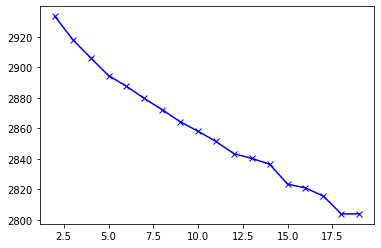

In [175]:
kmeans_ssd_plot(tfidf_en_matrix_01)

Kmeans clustering con k =  2
Kmeans clustering con k =  3
Kmeans clustering con k =  4
Kmeans clustering con k =  5
Kmeans clustering con k =  6
Kmeans clustering con k =  7
Kmeans clustering con k =  8
Kmeans clustering con k =  9
Kmeans clustering con k =  10
Kmeans clustering con k =  11
Kmeans clustering con k =  12
Kmeans clustering con k =  13
Kmeans clustering con k =  14
Kmeans clustering con k =  15
Kmeans clustering con k =  16
Kmeans clustering con k =  17
Kmeans clustering con k =  18
Kmeans clustering con k =  19
Kmeans clustering con k =  20
Kmeans clustering con k =  21
Kmeans clustering con k =  22
Kmeans clustering con k =  23
Kmeans clustering con k =  24
Kmeans clustering con k =  25
Kmeans clustering con k =  26
Kmeans clustering con k =  27
Kmeans clustering con k =  28
Kmeans clustering con k =  29
Kmeans clustering con k =  30
Kmeans clustering con k =  31
Kmeans clustering con k =  32
Kmeans clustering con k =  33
Kmeans clustering con k =  34
Kmeans clustering 

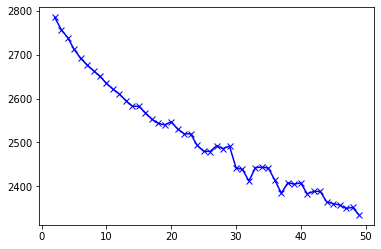

In [84]:
kmeans_ssd_plot(tfidf_en_matrix_05)

Kmeans clustering con k =  2
Kmeans clustering con k =  3
Kmeans clustering con k =  4
Kmeans clustering con k =  5
Kmeans clustering con k =  6
Kmeans clustering con k =  7
Kmeans clustering con k =  8
Kmeans clustering con k =  9
Kmeans clustering con k =  10
Kmeans clustering con k =  11
Kmeans clustering con k =  12
Kmeans clustering con k =  13
Kmeans clustering con k =  14
Kmeans clustering con k =  15
Kmeans clustering con k =  16
Kmeans clustering con k =  17
Kmeans clustering con k =  18
Kmeans clustering con k =  19
Kmeans clustering con k =  20
Kmeans clustering con k =  21
Kmeans clustering con k =  22
Kmeans clustering con k =  23
Kmeans clustering con k =  24
Kmeans clustering con k =  25
Kmeans clustering con k =  26
Kmeans clustering con k =  27
Kmeans clustering con k =  28
Kmeans clustering con k =  29
Kmeans clustering con k =  30
Kmeans clustering con k =  31
Kmeans clustering con k =  32
Kmeans clustering con k =  33
Kmeans clustering con k =  34
Kmeans clustering 

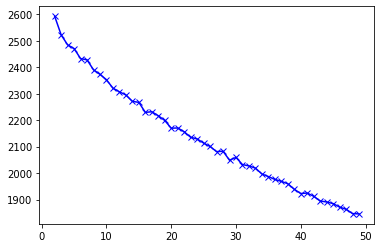

In [85]:
kmeans_ssd_plot(tfidf_en_matrix_10)

Si sceglie un valore di k=15, si performa il clustering e si aggiunge l'informazione di labeling al dataframe.
Eventualmente sarà possibile unificare i cluster simili tra loro confrontandoli con un algoritmo custom.

In [14]:
k=5

model = KMeans(n_clusters=k, max_iter=300, n_init=20)
model.fit(tfidf_en_matrix_01)
df_en['label_kmeans_01']=model.labels_

model = KMeans(n_clusters=k, max_iter=300, n_init=20)
model.fit(tfidf_en_matrix_05)
df_en['label_kmeans_05']=model.labels_

model = KMeans(n_clusters=k, max_iter=300, n_init=20)
model.fit(tfidf_en_matrix_10)
df_en['label_kmeans_10']=model.labels_

model = KMeans(n_clusters=k, max_iter=300, n_init=20)
model.fit(tfidf_en_matrix_PCA)
df_en['label_kmeans_PCA']=model.labels_


In [16]:
 def cluster_eval(X, k):
    #++++++++++PER CLUSTER SSE+++++++++++++++++++
    model = KMeans(n_clusters=k, max_iter=300, n_init=20).fit(X)
    cluster_centers = [X[model.labels_ == i].mean(axis=0) for i in range(k)]

    clusterwise_sse= [0 for x in range(k)] #VETTORE DI SSE PER OGNI CLUSTER
    for point, label in zip(X, model.labels_):
        clusterwise_sse[label] += np.square(point - cluster_centers[label]).sum()

    #-------------SILHOUETTE-----------------------
    from sklearn.metrics import silhouette_score, silhouette_samples


    silhouette_avg = silhouette_score(X, model.labels_)
    sample_silhouette_values = silhouette_samples(X, model.labels_)

    print("La clusterizzazione ha prodotto cluster con coefficiente di silhouette pari a", silhouette_avg)

    import matplotlib.cm as cm
    

    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 0.3])
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])



    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % k),
                    fontsize=14, fontweight='bold')

    plt.show()
    plt.hist(clusterwise_sse, k)
    


La clusterizzazione ha prodotto cluster con coefficiente di silhouette pari a 0.015076829643518872


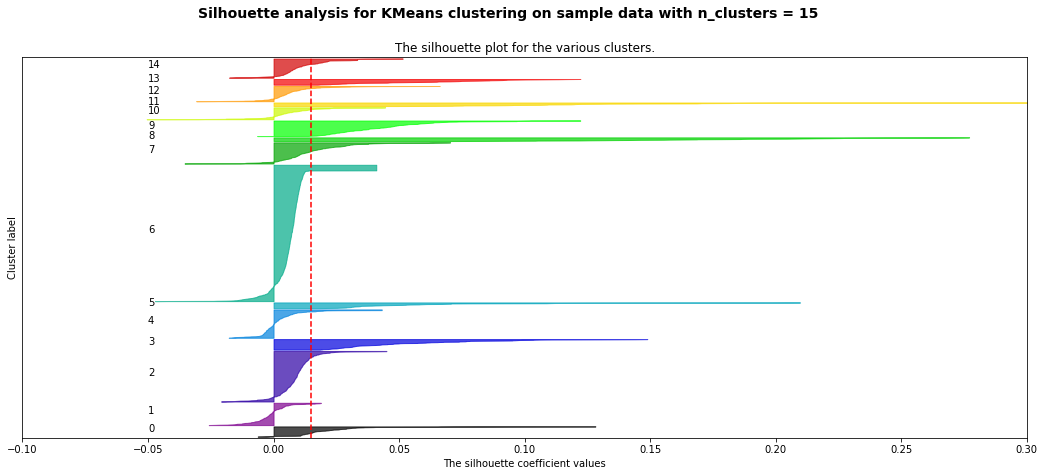

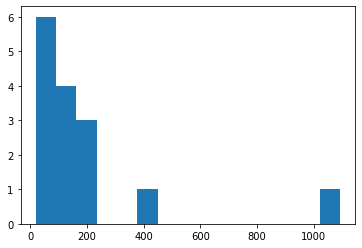

In [99]:
cluster_eval(tfidf_en_matrix_01, 15)

## Test regole di associazione
viene testato l'algoritmo apriori sulla versione onehot encoded della tfidf del dataset. La colonna "covid" viene droppata in quanto estremamente frequente e quindi non informativa

In [101]:
M = tf_idf_en_00
M=M.drop('covid', axis='columns')
def onehot(r):
    if r==0:
        return 0
    else:
        return 1

M = M.applymap(onehot)

from mlxtend.frequent_patterns import apriori, association_rules
freq_items = apriori(M, min_support=0.005, use_colnames=True)
rules = association_rules(freq_items, metric='confidence', min_threshold=0.3)
rules

rules.to_excel('rules.xlsx')


In [40]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(000),(covid),0.021332,0.711191,0.017722,0.830769,1.168137,0.002551,1.706597
1,(2020),(covid),0.016081,0.711191,0.015097,0.938776,1.320004,0.003660,4.717208
2,(2021),(covid),0.022973,0.711191,0.022317,0.971429,1.365917,0.005979,10.108303
3,(american),(covid),0.018379,0.711191,0.016738,0.910714,1.280547,0.003667,3.234657
4,(announc),(covid),0.012143,0.711191,0.011815,0.972973,1.368089,0.003179,10.685921
...,...,...,...,...,...,...,...,...,...
140,(receiv),"(covid, vaccin)",0.023630,0.185756,0.019363,0.819444,4.411391,0.014974,4.509656
141,"(covid, senat)",(relief),0.018051,0.028881,0.011487,0.636364,22.034091,0.010965,2.670578
142,"(relief, senat)",(covid),0.011487,0.711191,0.011487,1.000000,1.406091,0.003317,inf
143,(senat),"(covid, relief)",0.020676,0.026912,0.011487,0.555556,20.643631,0.010930,2.189449


## VAlutazione qualitativa dei cluster utilizzando una Wordcloud

Questo è il codice per generare Wordcloud


In [40]:

from wordcloud import WordCloud
def cloud_OLD(df, label, ncluster, text_index='text_clean'):

    frequent_words=['texas']
    df_0 = df.loc[df[label]==ncluster]
    text = df_0[text_index].str.cat(sep='')
    text = text.lower()
    text=' '.join([word for word in text.split() if not word in frequent_words])
    wordcloud = WordCloud(max_font_size=300, max_words=100, background_color="white", width=1920, height=1080).generate(text)
    fig1 = plt.figure(figsize=(6,6))
    fig1.set_size_inches(18, 7)
    plt.imshow(wordcloud)
    print(text)

In [50]:
from wordcloud import WordCloud
def cloud(df, label, ncluster, text_index='text_clean'):

    frequent_words=['covid', 're']
    

    df_0 = df.loc[df[label]==ncluster]
    text = []
    for twt in df_0[text_index]:
        token_words = word_tokenize(twt) #tokenizzazione
        token_filter_words_1 = [w for w in token_words if not w in stop_words]
        token_filter_words_2 = [w for w in token_filter_words_1 if not w in frequent_words] #stopword filtering
        for w in token_filter_words_2:
            text.append(w)
    
    
    txt=' '.join([word for word in text])
    wordcloud = WordCloud(max_font_size=300, max_words=100, background_color="white", width=1920, height=1080).generate(txt)
    fig1 = plt.figure(figsize=(6,6))
    fig1.set_size_inches(18, 7)
    plt.imshow(wordcloud)
    
    

DA FARE: Funzione di "valutazione del cluster" che comprende tutte le metriche utili a valutare il cluster compreso il wordcloud.
* SSE (se possibile recuperarlo da sopra, forse conviene effettuare il clustering all interno della funzione)
* silhouette
* numero di elementi per cluster (forse un grafico?)

Commenti: praticamente tutti i cluster parlano di vaccino ma si riescono a distinguere cluster che parlano di:
* mascherine
* tweet aggressivi (verso le mascherine)
* tweet che parlano dei dati
* tweet che parlano della politica insieme ai vaccini

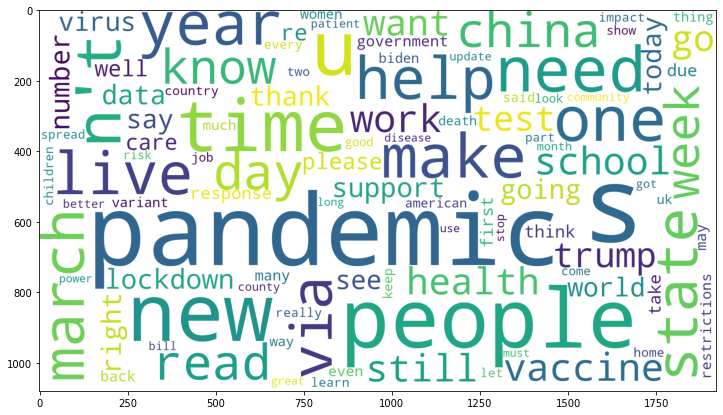

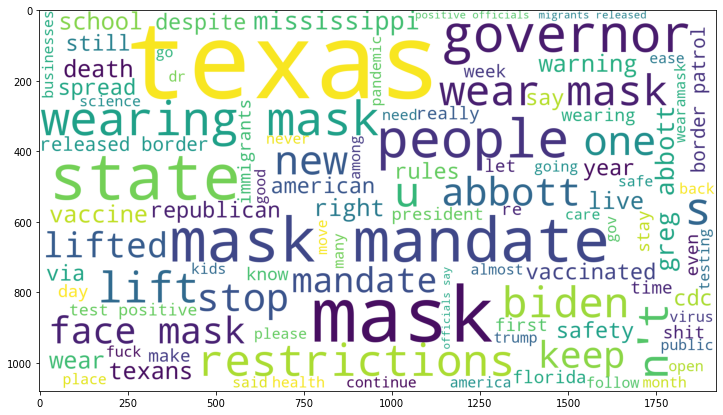

In [80]:
cloud(df_en, 'label_kmeans_01', 0)
cloud(df_en, 'label_kmeans_01', 4)

## Esaminazione dei cluster

C:\Users\giuli\AppData\Local\Temp/ipykernel_10940/418535679.py:20: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(figure)


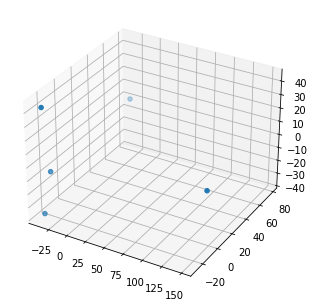

In [103]:
#visualizzazione dei centroidi tramite PCA

M = model.cluster_centers_

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#Standardizzo i dati
scaler = StandardScaler()
M = scaler.fit_transform(M)

#Applico la PCA mantenendo le prime 3 componenti
pca=PCA(n_components=3)
M = pca.fit_transform(M)

#scatter 3d dei centroidi prodotti
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

figure = pyplot.figure()
ax = Axes3D(figure)

ax.scatter(M[:,0], M[:,1], M[:,2])
pca.explained_variance_

pyplot.show()

# CODICE SPERIMENTALE - IGNORA

# Utilizo del DB-SCAN per raggruppare i cluster

In [104]:
from sklearn.cluster import DBSCAN
M= model.cluster_centers_
pca=PCA(0.95)
M= pca.fit_transform(scaler.fit_transform(M))

clustering = DBSCAN(eps=1, metric='cosine').fit(model.cluster_centers_)
clustering.labels_

array([0, 0, 0, 0, 0], dtype=int64)

# DB Scan Clustering

In [53]:
scaler = StandardScaler()
from sklearn.neighbors import NearestNeighbors
M=scaler.fit_transform(tfidf_en_matrix_00)

nbrs = NearestNeighbors(n_neighbors=5, radius=20, n_jobs=-1).fit(M)
distances, indices = nbrs.kneighbors(M)
distances_plot = [d[4] for d in distances ]
#print(indices[0],distances[0])

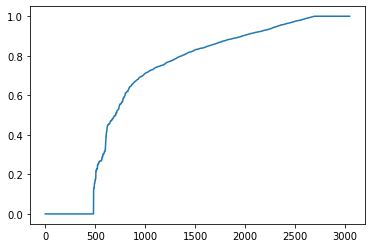

In [54]:
distances_plot.sort()
plt.plot(range(M.shape[0]), distances_plot)


In [55]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.8, min_samples=5).fit(M)


df_en['labels_DBSCAN']= clustering.labels_
df_en.loc[df_en['labels_DBSCAN']==0]




,Unnamed: 0,favorite_count,source,text_enc,text_clean,is_retweet,retweet_count,created_at_ntz,mentions,hashtags,links,text_stem,labels_DBSCAN
2,2,0,Twitter for Android,#Coronavirus\nAustria and Denmark are to stop ...,covid\naustria and denmark are to stop relying...,False,0,2021-03-03 08:47:26,0,2,1,covid austria denmark stop reli sole european ...,0
3,3,0,Twitter Web App,BMC launches ‘Mission Zero’ in Mumbai again to...,bmc launches ‘mission zero’ in mumbai again to...,False,0,2021-03-01 12:23:57,0,0,1,bmc launch ‘ mission zero ’ mumbai combat covid,0
4,4,0,Twitter for iPhone,@Gadaffyduck @IsabelOakeshott @AmandaHolden Du...,dude.. y’all sound like the idiots. y’all b...,False,0,2021-03-04 20:49:11,3,0,1,dude .. ’ sound like idiot . ’ believ industri...,0
5,5,0,Hootsuite Inc.,COVID-19 Shows Need for New Nursing Home Model...,covid shows need for new nursing home model — ...,False,0,2021-03-01 20:45:03,0,0,1,covid show need new nurs home model — ’ happen...,0
7,7,1,Twitter for iPhone,They Are Literally Telling Yall They Clicked U...,they are literally telling yall they clicked u...,False,1,2021-03-02 14:11:17,0,0,1,liter tell yall click tri kill us . 2+2=4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4157,4157,0,Fabrik.fm,National News | The National Press Club (NPC) ...,national news | the national press club (npc) ...,False,0,2021-03-07 13:45:55,0,0,2,nation news | nation press club ( npc ) name c...,0
4160,4160,0,Twitter for Android,COVID-19 Anal Swabs Now Mandatory For Foreigne...,covid anal swabs now mandatory for foreigners,False,0,2021-03-03 22:55:41,0,0,1,covid anal swab mandatori foreign,0
4163,4163,4,Tweetbot for Mac,"In other news, I have been jabbed with the fir...","in other news, i have been jabbed with the fir...",False,0,2021-03-02 19:18:52,0,0,0,"news , jab first dose covid vaccin today , une...",0
4165,4165,2,Twitter for Android,"Read this\n\nThen read it again\n\nWritten, pr...","read this\n\nthen read it again\n\nwritten, pr...",False,1,2021-03-04 07:46:47,0,0,1,"read read written , presum journalist without ...",0


In [56]:
df_en.loc[df_en['labels_DBSCAN']==-1]

,Unnamed: 0,favorite_count,source,text_enc,text_clean,is_retweet,retweet_count,created_at_ntz,mentions,hashtags,links,text_stem,labels_DBSCAN
1,1,0,Twitter for iPhone,@TitusNation the CON serving CONservative GOP ...,the con serving conservative gop = ghouls of ...,False,0,2021-03-03 17:22:21,1,1,0,"con serv conserv gop = ghoul polit , group per...",-1
13,13,0,SocialFlow,VACCINATIONS: The White House COVID-19 respons...,vaccinations: the white house covid response t...,False,0,2021-03-03 20:30:06,0,0,1,vaccin : white hous covid respons team brief p...,-1
14,14,0,Hootsuite Inc.,"""During our rapid response to the COVID-19 pan...","""during our rapid response to the covid pandem...",False,0,2021-03-01 22:15:06,0,0,1,"`` rapid respons covid pandem , hospit health ...",-1
16,16,2,TweetDeck,3-D Commissioner Georges C. Benjamin of @Publi...,"3-d commissioner georges c. benjamin of says,...",False,0,2021-03-02 22:00:00,1,2,1,"3-d commission georg c. benjamin say , “ way e...",-1
19,19,1,Twitter Web App,@green___arrow__ @HMOIndia @drharshvardhan @sh...,"""there is currently limited information on...",False,0,2021-03-06 05:36:44,4,0,1,`` current limit inform much covid vaccin migh...,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4158,4158,0,Twitter Web App,"Va. COVID-19 March 7 update: Over 1,100 new ca...","va. covid march 7 update: over 1,100 new cases...",False,0,2021-03-07 23:59:13,0,0,1,"va. covid march 7 updat : 1,100 new case , 800...",-1
4161,4161,7,Twitter for Android,@JoePorterUK Wow! Very few people regard the s...,wow! very few people regard the sacrifice of ...,False,0,2021-03-06 01:20:25,1,0,0,wow ! peopl regard sacrific nurs 've swum dail...,-1
4162,4162,0,IFTTT,"Biden announces distribution of $1,400 Covid-1...","biden announces distribution of $1,400 covid r...",False,0,2021-03-07 08:36:43,0,0,1,"biden announc distribut $ 1,400 covid relief p...",-1
4164,4164,5,Twitter Web App,So nearly 10% of today's new cases are the new...,so nearly 10% of today's new cases are the new...,False,4,2021-03-04 22:56:28,0,1,1,nearli 10 % today 's new case new variant ? we...,-1


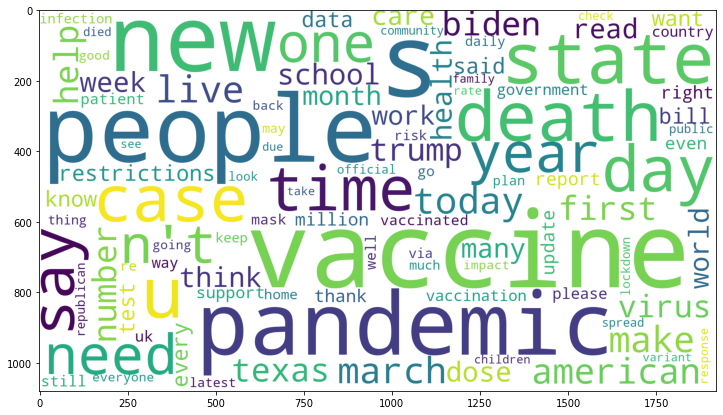

In [57]:
cloud(df_en, 'labels_DBSCAN', -1)

In [ ]:
from wordcloud import WordCloud

df_en_0 = df_en.loc[df_en['labels_DBSCAN']==4]
text = df_en_0['text_clean'].str.cat(sep='')
text = text.lower()
text=' '.join([word for word in text.split()])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig1 = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)

In [119]:
tf_idf_en.reset_index(drop=True, inplace=True )
df_en.reset_index(drop=True, inplace=True)
df_en_concat = pd.concat([df_en, tf_idf_en], axis=1)
df_en_concat.to_excel('df_en_concat.xlsx')


In [98]:
tf_idf_en.to_excel('tf_idf_en.xlsx')